# Подготовка модели распознавания рукописных букв и цифр

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize, Lambda
from torchvision.transforms.functional import rotate, hflip
from torchvision.datasets import EMNIST
from torchinfo import summary
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = EMNIST('data/', 'balanced', download=False)

In [2]:
mapping = {}

with open('data/EMNIST/raw/emnist-balanced-mapping.txt', 'r') as f:
    for line in f:
        label, code = line.strip().split()
        mapping[int(label)] = chr(int(code))
        
mapping

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

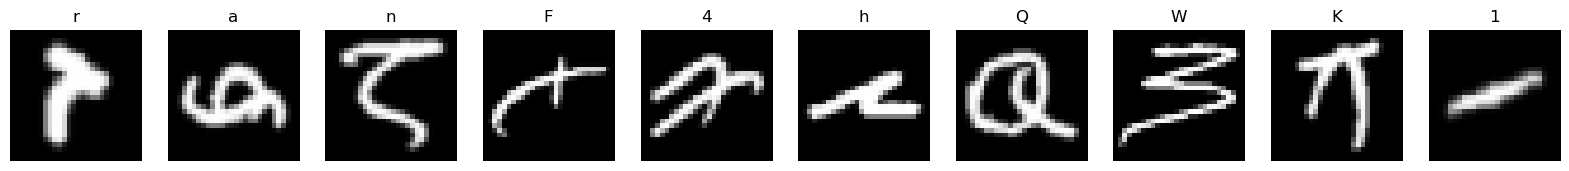

In [3]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(dataset[i][0], cmap='gray')
    axs[i].set_title(mapping[dataset[i][1]])
    axs[i].axis('off')
plt.show()

In [4]:
transform = Compose([
    Lambda(lambda x: rotate(x, -90)),
    Lambda(lambda x: hflip(x)),
    ToTensor(),
    Normalize([0.5], [0.5])
])

train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)

In [5]:
train_counts = {i: 0 for i in mapping.values()}
for _, target in train_dataset:
    symbol = mapping[int(target)]
    train_counts[symbol] += 1

val_counts = {i: 0 for i in mapping.values()}
for _, target in val_dataset:
    symbol = mapping[int(target)]
    val_counts[symbol] += 1
    
print(train_counts)
print(val_counts)

{'0': 2400, '1': 2400, '2': 2400, '3': 2400, '4': 2400, '5': 2400, '6': 2400, '7': 2400, '8': 2400, '9': 2400, 'A': 2400, 'B': 2400, 'C': 2400, 'D': 2400, 'E': 2400, 'F': 2400, 'G': 2400, 'H': 2400, 'I': 2400, 'J': 2400, 'K': 2400, 'L': 2400, 'M': 2400, 'N': 2400, 'O': 2400, 'P': 2400, 'Q': 2400, 'R': 2400, 'S': 2400, 'T': 2400, 'U': 2400, 'V': 2400, 'W': 2400, 'X': 2400, 'Y': 2400, 'Z': 2400, 'a': 2400, 'b': 2400, 'd': 2400, 'e': 2400, 'f': 2400, 'g': 2400, 'h': 2400, 'n': 2400, 'q': 2400, 'r': 2400, 't': 2400}
{'0': 400, '1': 400, '2': 400, '3': 400, '4': 400, '5': 400, '6': 400, '7': 400, '8': 400, '9': 400, 'A': 400, 'B': 400, 'C': 400, 'D': 400, 'E': 400, 'F': 400, 'G': 400, 'H': 400, 'I': 400, 'J': 400, 'K': 400, 'L': 400, 'M': 400, 'N': 400, 'O': 400, 'P': 400, 'Q': 400, 'R': 400, 'S': 400, 'T': 400, 'U': 400, 'V': 400, 'W': 400, 'X': 400, 'Y': 400, 'Z': 400, 'a': 400, 'b': 400, 'd': 400, 'e': 400, 'f': 400, 'g': 400, 'h': 400, 'n': 400, 'q': 400, 'r': 400, 't': 400}


In [6]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)

In [7]:
def train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre):
    model.to(device)
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        current_lr = get_current_lr(optimizer)
        print(f'Current Learning Rate: {current_lr}')
        for step, (data, target) in enumerate(train_loader):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            
            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')

        if epoch % val_fre == 0:
            val_loss = validate(model, val_loader, loss_f)
            scheduler.step(val_loss)

def validate(model, val_loader, loss_f):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}')
    model.train()
    return loss_sum / (step + 1)

def get_current_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [8]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Dropout(0.25),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Dropout(0.25),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=12544, out_features=6272),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(in_features=6272, out_features=3136),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(in_features=3136, out_features=n_classes)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.classifier(x)
        return x
    
net = CNN(47)
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 47]                   --
├─Sequential: 1-1                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─ReLU: 2-3                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 32, 14, 14]           --
│    └─Dropout: 2-5                      [1, 32, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 64, 14, 14]           51,264
│    └─BatchNorm2d: 2-7                  [1, 64, 14, 14]           128
│    └─ReLU: 2-8                         [1, 64, 14, 14]           --
│    └─Dropout: 2-9                      [1, 64, 14, 14]           --
│    └─Conv2d: 2-10                      [1, 128, 14, 14]          401,536
│    └─BatchNorm2d: 2-11                 [1, 128, 14, 14]          256
│  

In [9]:
%%time

model = CNN(47)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

n_epoch = 30
val_fre = 2

train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
validate(model, val_loader, loss_f)

Epoch: 0
Current Learning Rate: 0.1
Iter: 0 	Loss: 3.8632583618164062
Iter: 10 	Loss: 4.171310901641846
Iter: 20 	Loss: 2.478304862976074
Iter: 30 	Loss: 1.2813737392425537
Iter: 40 	Loss: 0.8724743723869324
Iter: 50 	Loss: 0.7259830236434937
Iter: 60 	Loss: 0.6013151407241821
Iter: 70 	Loss: 0.5402480363845825
Iter: 80 	Loss: 0.5417232513427734
Iter: 90 	Loss: 0.5266383290290833
Iter: 100 	Loss: 0.517001748085022
Iter: 110 	Loss: 0.4685957431793213
Mean Train Loss: 1.251415

Val Loss: 0.423857 	Accuracy: 0.8523936170212766
Epoch: 1
Current Learning Rate: 0.1
Iter: 0 	Loss: 0.4282047152519226
Iter: 10 	Loss: 0.42521724104881287
Iter: 20 	Loss: 0.4193362295627594
Iter: 30 	Loss: 0.45203927159309387
Iter: 40 	Loss: 0.3992222249507904
Iter: 50 	Loss: 0.36989325284957886
Iter: 60 	Loss: 0.4072627127170563
Iter: 70 	Loss: 0.4120623767375946
Iter: 80 	Loss: 0.4268612861633301
Iter: 90 	Loss: 0.3653380870819092
Iter: 100 	Loss: 0.37032511830329895
Iter: 110 	Loss: 0.36708396673202515
Mean Tra

Mean Train Loss: 0.172620

Epoch: 16
Current Learning Rate: 0.010000000000000002
Iter: 0 	Loss: 0.15164650976657867
Iter: 10 	Loss: 0.16147348284721375
Iter: 20 	Loss: 0.17757946252822876
Iter: 30 	Loss: 0.1483660787343979
Iter: 40 	Loss: 0.18232876062393188
Iter: 50 	Loss: 0.18739904463291168
Iter: 60 	Loss: 0.14118686318397522
Iter: 70 	Loss: 0.14825505018234253
Iter: 80 	Loss: 0.17571276426315308
Iter: 90 	Loss: 0.16858452558517456
Iter: 100 	Loss: 0.14754618704319
Iter: 110 	Loss: 0.16547055542469025
Mean Train Loss: 0.166541

Val Loss: 0.305364 	Accuracy: 0.9012234042553191
Epoch: 17
Current Learning Rate: 0.010000000000000002
Iter: 0 	Loss: 0.15442335605621338
Iter: 10 	Loss: 0.17026671767234802
Iter: 20 	Loss: 0.15187062323093414
Iter: 30 	Loss: 0.14468683302402496
Iter: 40 	Loss: 0.17007185518741608
Iter: 50 	Loss: 0.13838733732700348
Iter: 60 	Loss: 0.1547776311635971
Iter: 70 	Loss: 0.1599927544593811
Iter: 80 	Loss: 0.13198819756507874
Iter: 90 	Loss: 0.1556570827960968
Iter

0.316923168144728

In [10]:
# посмотрим ещё раз на метрики и самые частые ошибки в валидацинном наборе данных:

def get_most_common_errors(cm, label_mapping, threshold=10):
    errors = np.where((cm - np.diag(np.diag(cm))) > threshold)
    error_list = []
    for true_label, pred_label in zip(errors[0], errors[1]):
        true_symbol = label_mapping[true_label]
        pred_symbol = label_mapping[pred_label]
        error_count = cm[true_label, pred_label]
        error_list.append((true_symbol, pred_symbol, error_count))
        
    sorted_errors = sorted(error_list, key=lambda x: x[2], reverse=True)
    
    return sorted_errors

def evaluate(model, data_loader, loss_f):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_f(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, accuracy, f1, cm

val_loss, val_accuracy, val_f1, val_cm = evaluate(model, val_loader, loss_f)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {val_f1:.4f}\n")

sorted_errors = get_most_common_errors(val_cm, mapping)
for true_symbol, pred_symbol, error_count in sorted_errors:
    print(f"True: {true_symbol}, Predicted: {pred_symbol}, Error rate: {error_count}")

Val Loss: 0.3169, Val Accuracy: 0.9022, Val F1-Score: 0.9016

True: F, Predicted: f, Error rate: 138
True: L, Predicted: 1, Error rate: 137
True: O, Predicted: 0, Error rate: 119
True: f, Predicted: F, Error rate: 94
True: 0, Predicted: O, Error rate: 89
True: q, Predicted: 9, Error rate: 89
True: I, Predicted: 1, Error rate: 87
True: L, Predicted: I, Error rate: 59
True: 1, Predicted: L, Error rate: 53
True: 1, Predicted: I, Error rate: 50
True: g, Predicted: q, Error rate: 41
True: g, Predicted: 9, Error rate: 37
True: q, Predicted: g, Error rate: 35
True: 9, Predicted: q, Error rate: 32
True: I, Predicted: L, Error rate: 30
True: 2, Predicted: Z, Error rate: 29
True: 5, Predicted: S, Error rate: 27
True: 9, Predicted: g, Error rate: 27
True: Z, Predicted: 2, Error rate: 23
True: t, Predicted: T, Error rate: 20
True: T, Predicted: t, Error rate: 15
True: b, Predicted: 6, Error rate: 15
True: 6, Predicted: b, Error rate: 14
True: D, Predicted: 0, Error rate: 14
True: S, Predicted: 5, 

In [11]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, 'myapp/model.ckpt')